In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score, mean_squared_error
import matplotlib.colors
from IPython.display import HTML
from tqdm import tqdm_notebook
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import load_iris
from numpy.linalg import norm

In [ ]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list('', ['red', 'yellow', 'green'])

In [ ]:
iris = load_iris()
X = iris.data
Y = iris.target

In [ ]:
print(X.shape, Y.shape)

(150, 4) (150,)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, stratify = Y, random_state=0, test_size = 0.2)

In [ ]:
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(120, 4) (30, 4) (120,) (30,)


In [ ]:
enc = OneHotEncoder()
Y_enc_train = enc.fit_transform(np.expand_dims(Y_train, 1)).toarray()
Y_enc_test = enc.fit_transform(np.expand_dims(Y_test, 1)).toarray()

In [ ]:
print(Y_enc_train.shape, Y_enc_test.shape)

(120, 3) (30, 3)


In [ ]:
class FFN_overfit:
  def __init__(self, hidden_size = 2, initialization = 'xavier', activation = 'sigmoid', leaky_slop = 0.1):

    self.params = {}
    self.activation = activation
    self.initialization = initialization
    self.gradients = {}
    self.no_layers = 2
    self.layer_sizes = [4, hidden_size, 3]

    if self.initialization == 'random':
      for i in range(1, self.no_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
    elif self.initialization == 'zero':
      for i in range(1, self.no_layers+1):
        self.params['W'+str(i)] = np.zeros((self.layer_sizes[i-1], self.layer_sizes[i]))
        self.params['B'+str(i)] = np.zeros((1, self.layer_sizes[i]))
    
    elif self.initialization == 'HE':
      for i in range(1, self.no_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(2 / self.layer_sizes[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
    elif self.initialization == 'xavier':
      for i in range(1, self.no_layers+1):
        self.params['W'+str(i)] = np.random.randn(self.layer_sizes[i-1], self.layer_sizes[i])*np.sqrt(1 / self.layer_sizes[i-1])
        self.params['B'+str(i)] = np.random.randn(1, self.layer_sizes[i])
    
  def forward_activation(self, X):
    if self.activation == 'sigmoid':
      return 1/(1+np.exp(-X))
    
    elif self.activation == 'tanh':
      return np.tanh(X)
    
    elif self.activation == 'ReLu':
      return np.maximum(0, X)
    
    elif self.activation == 'Leaky_ReLu':
      return np.maximum(X*self.leaky_slop, X)
  
  def grad_activation(self, X):
    if self.activation == 'sigmoid':
      return X * (1-X)
    
    elif self.activation == 'tanh':
      return 1 - np.square(X)
    
    elif self.activation == 'ReLu':
      return (X>0)
    
    elif self.activation == 'Leaky_ReLu':
      d = np.zeros_like(X)
      d[X<=0] = self.leaky_slop
      d[X>0] = 1
      return d
  
  def softmax(self, X):
    exps = np.exp(X)
    return exps / np.sum(exps, 1).reshape(-1, 1)

  def forward_pass(self, X, params = None):
    if params == None:
      params = self.params
    
    self.A1 = np.matmul(X, params['W1']) + self.params['B1'] # (N, 4) * (4, 2) + (1, 2) -> (N, 2)
    self.H1 = self.forward_activation(self.A1)
    self.A2 = np.matmul(self.H1, self.params['W2']) + self.params['B2'] # (N, 2) * (2, 3) + (1, 3) -> (N, 3)
    self.H2 = self.softmax(self.A2)
    return self.H2  # (N, 3)
  
  def grad(self, X, Y, params = None):
    if params == None:
      params = self.params
    
    self.forward_pass(X, params)
    self.gradients['dA2'] = self.H2 - Y # (N, 3)
    self.gradients['dW2'] = np.matmul(self.H1.T, self.gradients['dA2']) # (2, N) * (N, 3) -> (2, 3)
    self.gradients['dB2'] = np.sum(self.gradients['dA2'], 0).reshape(1, -1)  # (1, 3)
    self.gradients['dH1'] = np.matmul(self.gradients['dA2'], self.params['W2'].T)  # (N, 3) * (3, 2) -> (N, 2)
    self.gradients['dA1'] = np.multiply(self.gradients['dH1'], self.grad_activation(self.H1))  # (N, 2) * (N, 2) -> (N, 2)
    self.gradients['dW1'] = np.matmul(X.T, self.gradients['dA1']) # (4, N) * (N, 2) -> (4, 2)
    self.gradients['dB1'] = np.sum(self.gradients['dA1'], 0).reshape(1, -1)  # (1, 2)
  
  def get_accuracy(self):
    Y_pred_train = self.predict(X_train)
    Y_pred_train = np.argmax(Y_pred_train, 1)
    Y_pred_test = self.predict(X_test)
    Y_pred_test = np.argmax(Y_pred_test, 1)
    train_acc = accuracy_score(Y_train, Y_pred_train)
    test_acc = accuracy_score(Y_test, Y_pred_test)
    return train_acc, test_acc
  
  def fit(self, X, Y, epochs = 100, lr = 0.1, l2_norm = False, lambda_val=0.1):
    loss, train_accuracy, test_accuracy, weight_mag = {}, {}, {}, []
    m = X.shape[0]
    for epoch in tqdm_notebook(range(epochs), total = epochs, unit = 'epoch'):
      self.grad(X, Y)
      for i in range(1, self.no_layers+1):
        if l2_norm:
          self.params['W'+str(i)] -= (lr*lambda_val) / m * self.params['W'+str(i)] + lr * self.gradients['dW'+str(i)] / m
        else:
          self.params['W'+str(i)] -= lr * (self.gradients['dW'+str(i)] / m)
        self.params['B'+str(i)] -= lr * (self.gradients['dB'+str(i)] / m)
      Y_pred = self.predict(X)
      loss[epoch] = log_loss(np.argmax(Y, 1), Y_pred)
      train_accuracy[epoch], test_accuracy[epoch] = self.get_accuracy()
      weight_mag.append((norm(self.params['W1']) + norm(self.params['W2']) + norm(self.params['B1']) + norm(self.params['B2']) / 22))
    
    plt.plot(list(train_accuracy.values()),label="Train accuracy")
    plt.plot(list(test_accuracy.values()),label="Validation accuracy")
    plt.plot(np.ones((epochs, 1))*0.9)
    plt.plot(np.ones((epochs, 1))*0.33)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.set_xlabel('epochs')
    ax1.set_ylabel('Log Loss', color=color)
    ax1.plot(list(loss), '-o', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Weight Magnitude', color=color)  # we already handled the x-label with ax1
    ax2.plot(weight_mag, '-*', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    fig.tight_layout()  
    plt.show()
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return np.array(Y_pred).squeeze()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


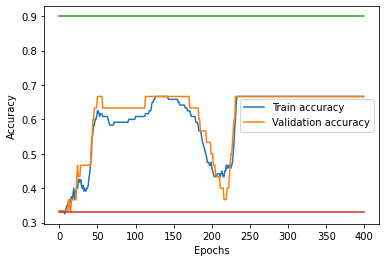

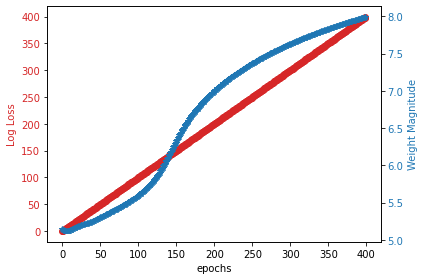

(0.6666666666666666, 0.6666666666666666)


In [ ]:
model = FFN_overfit(activation='tanh')
model.fit(X_train, Y_enc_train, epochs = 400)
print(model.get_accuracy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


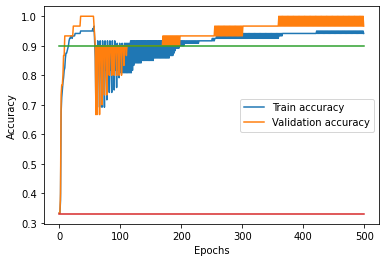

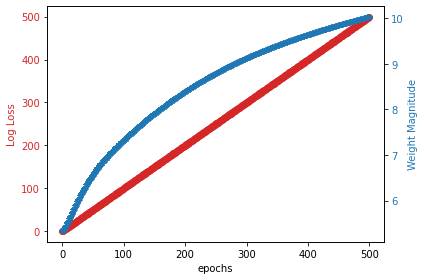

(0.9416666666666667, 0.9666666666666667)


In [ ]:
model = FFN_overfit(activation='tanh', hidden_size=4)
model.fit(X_train, Y_enc_train, epochs = 500)
print(model.get_accuracy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


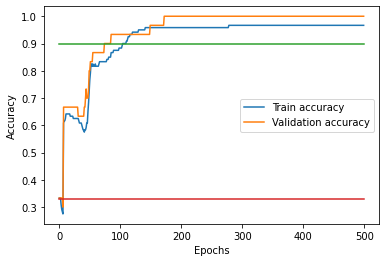

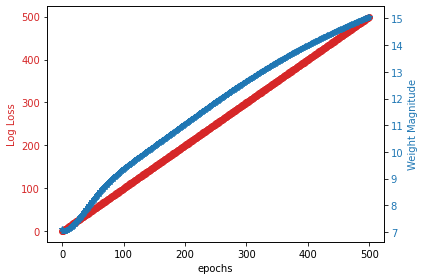

(0.9666666666666667, 1.0)


In [ ]:
model = FFN_overfit(hidden_size=8)
model.fit(X_train, Y_enc_train, epochs=500, lr=0.2)
print(model.get_accuracy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


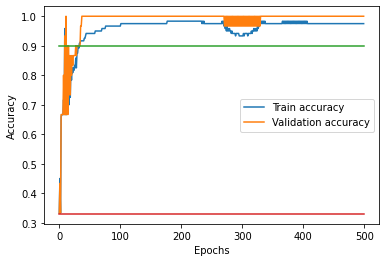

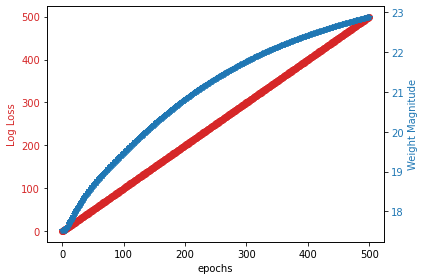

(0.975, 1.0)


In [ ]:
model = FFN_overfit(hidden_size=64)
model.fit(X_train, Y_enc_train, epochs=500, lr=0.2, l2_norm=True)
print(model.get_accuracy())

0.01


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


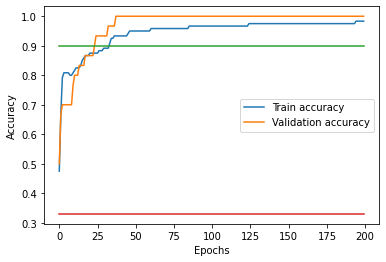

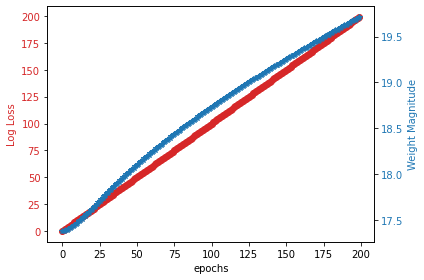

(0.9833333333333333, 1.0)
0.05


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


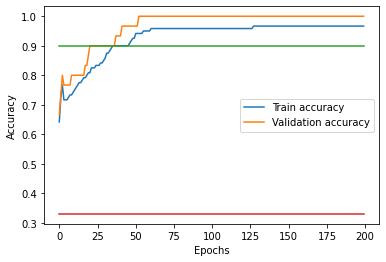

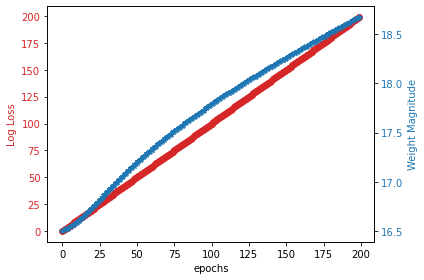

(0.9666666666666667, 1.0)
0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


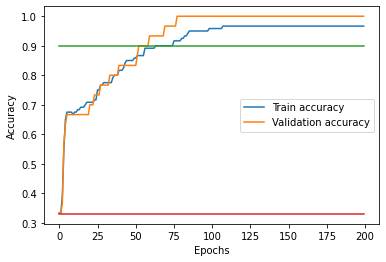

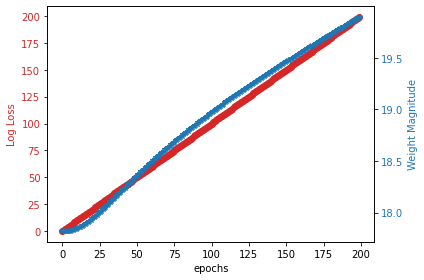

(0.9666666666666667, 1.0)
0.15


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


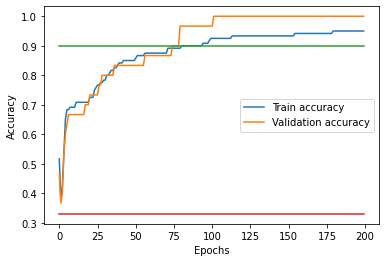

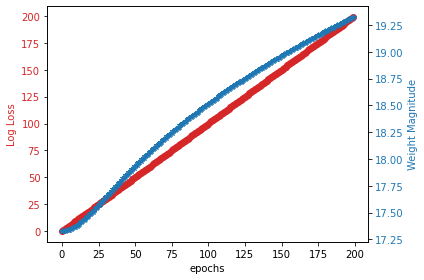

(0.95, 1.0)
0.18


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


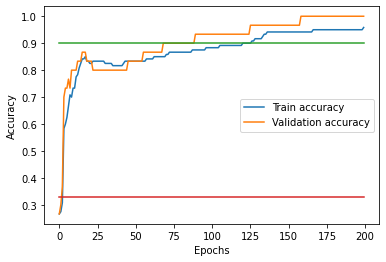

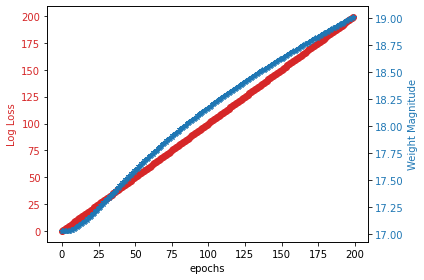

(0.9583333333333334, 1.0)
0.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


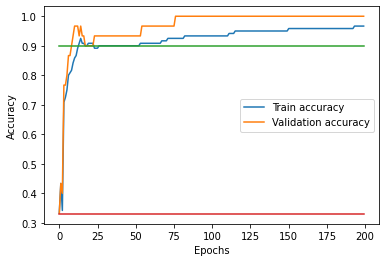

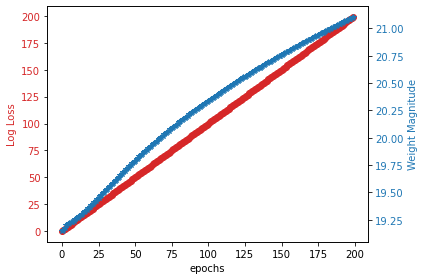

(0.9666666666666667, 1.0)


In [ ]:
for noise_fraction in [0.01, 0.05, 0.1, 0.15, 0.18, 0.2]:
  print(noise_fraction)
  X_train_noisy = X_train * (1 - noise_fraction*np.random.randn(X_train.shape[0], X_train.shape[1]))
  model = FFN_overfit(hidden_size=64)
  model.fit(X_train_noisy, Y_enc_train, epochs=200, lr=0.1, l2_norm=False)
  print(model.get_accuracy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


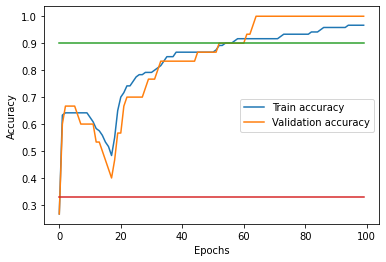

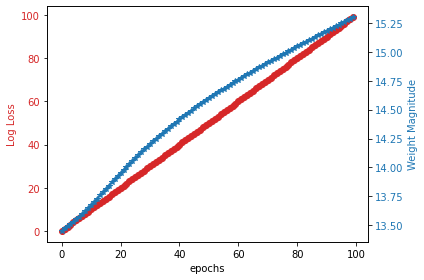

(0.9666666666666667, 1.0)


In [ ]:
model = FFN_overfit(hidden_size=32)
model.fit(X_train, Y_enc_train, epochs=100, lr=0.2, l2_norm=True)
print(model.get_accuracy())